# Compute (YOLO) detection accuracy
First, we'll import the ground truth video and blender tracked file

In [1]:
import numpy as np
import cv2
import csv
import os
import math
import time
import random
import sys
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from operator import itemgetter

# now for the file management fucntions
from Antrax_base import import_tracks, display_video, get_exact_frame, extractPatches, display_patches, sortByDistance

export_paths = ["D:/BENCHMARK/REAL/CLOSE_NEW/rec_outside_foraging_close_sparse_5000_frames/"] # add more paths here, if desired
video = "D:/BENCHMARK/REAL/CLOSE_NEW/rec_outside_foraging_close_sparse_5000_frames.mp4"

# enter the number of annotated frames:
tracked_frames = 999

# now we can load the captured video file and display it
cap = cv2.VideoCapture(video)

# check the number of frames of the imported video file
numFramesMax = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("The imported clip:", video, "has a total of",numFramesMax ,"frames.\n")

# now let's load all tracks listed in the export_paths
tracks = []

try:
    for folder in export_paths:
        # You can export all tracks into a single .csv file by setting "export=True"
        tracks.append(import_tracks(folder, numFramesMax, export=False))

        # The following function is used to display the tracks you imported.
        # You can press "q" while hovering over the displayed video to exit.
        print("\nDisplaying tracks loaded from:", folder)
        display_video(cap, tracks[-1], show=(0, tracked_frames), scale=0.3)# scale=1, output_file="C:/Users/Legos/Documents/PhD/Blender/OmniTrax/OmniTrax_WIP/benchmark/sub_colony_tracking/RESULTS/" + video[:-4].split("/")[-1] +'_annotations.avi')
except IndexError:
    print("WARNING: Issue importing tracks. Ensure correct numbers of frames are given")
"""
def import_ground_truth(path):
    tracks = np.loadtxt(path, delimiter=",")
    tracks = tracks.astype(int)
    
    print("Imported tracks successfully from", path)
    
    return tracks

tracks.append(import_ground_truth(path="J:/tracking_validation/export_base_NAT/_all_tracks.csv"))
"""

The imported clip: D:/BENCHMARK/REAL/CLOSE_NEW/rec_outside_foraging_close_sparse_5000_frames.mp4 has a total of 5017 frames.

importing tracks...
imported rec_outside_foraging_close_sparse_5000_frames_track_0.csv  with 92 points.
imported rec_outside_foraging_close_sparse_5000_frames_track_1.csv  with 40 points.
imported rec_outside_foraging_close_sparse_5000_frames_track_10.csv  with 379 points.
imported rec_outside_foraging_close_sparse_5000_frames_track_11.csv  with 999 points.
imported rec_outside_foraging_close_sparse_5000_frames_track_12.csv  with 145 points.
imported rec_outside_foraging_close_sparse_5000_frames_track_13.csv  with 134 points.
imported rec_outside_foraging_close_sparse_5000_frames_track_14.csv  with 999 points.
imported rec_outside_foraging_close_sparse_5000_frames_track_15.csv  with 999 points.
imported rec_outside_foraging_close_sparse_5000_frames_track_16.csv  with 687 points.
imported rec_outside_foraging_close_sparse_5000_frames_track_17.csv  with 999 points

'\ndef import_ground_truth(path):\n    tracks = np.loadtxt(path, delimiter=",")\n    tracks = tracks.astype(int)\n    \n    print("Imported tracks successfully from", path)\n    \n    return tracks\n\ntracks.append(import_ground_truth(path="J:/tracking_validation/export_base_NAT/_all_tracks.csv"))\n'

Next, we load our trained network and run inference on the loaded video 

In [5]:
# load darknet with compiled DLLs for windows from respective path
import sys
sys.path.append('C:/Users/Legos/Documents/PhD/Blender/OmniTrax/OmniTrax_WIP/build/darknet/x64/')
# load weights trained on synthetic data only
sys.path.append('C:/Users/Legos/Documents/PhD/Blender/OmniTrax/OmniTrax_WIP/YOLO/real_only_multi_class/')
# load weights trained on real data only
#sys.path.append('I:\\FARTS\\trained_YOLO_networks\\real_only_multi_class')
import darknet
import imutils

def nonMaximumSupression(detections):
    """
    :param detections: detections returned from darknet
    :return: only detection of highest confidence. Return None, if no individual was detected
    """
    if len(detections) != 0:
        det_sorted = sorted(detections, key=itemgetter(2))
        max_conf_detection = det_sorted[0][0]
    else:
        max_conf_detection = 'No Detect'
    return max_conf_detection

# load configuration and weights (synthetic)
yolo_cfg = 'C:/Users/Legos/Documents/PhD/Blender/OmniTrax/OmniTrax_WIP/YOLO/atta_single_class/yolov4-big_and_small_ants_640.cfg'
yolo_weights = 'C:/Users/Legos/Documents/PhD/Blender/OmniTrax/OmniTrax_WIP/YOLO/real_only_multi_class/yolov4-big_and_small_ants_6000.weights'
yolo_data = 'C:/Users/Legos/Documents/PhD/Blender/OmniTrax/OmniTrax_WIP/YOLO/atta_single_class/obj.data'
yolo_names = 'C:/Users/Legos/Documents/PhD/Blender/OmniTrax/OmniTrax_WIP/YOLO/atta_single_class/obj.names'

# load configuration and weights (real)
#yolo_cfg = 'I:/FARTS/trained_YOLO_networks/real_only_multi_class/yolov4_ant_weight_testing.cfg'
#yolo_weights = 'I:/FARTS/trained_YOLO_networks/real_only_multi_class/yolov4_ant_weight_24000.weights'
#yolo_data = 'I:/FARTS/trained_YOLO_networks/real_only_multi_class/data/obj.data'
#yolo_names = 'I:/FARTS/trained_YOLO_networks/real_only_multi_class/data/obj.names'

from ctypes import *
import math
import random
import os
import cv2
import numpy as np
import time
import darknet

def convertBack(x, y, w, h):
    xmin = int(round(x - (w / 2)))
    xmax = int(round(x + (w / 2)))
    ymin = int(round(y - (h / 2)))
    ymax = int(round(y + (h / 2)))
    return xmin, ymin, xmax, ymax


def cvDrawBoxes(detections, img, min_size=20, constant_size=False):
    for detection in detections:

        x, y, w, h = detection[2][0],\
            detection[2][1],\
            detection[2][2],\
            detection[2][3]
        
        if w >= min_size and h  >= min_size:
            
            if constant_size:
                w, h = constant_size, constant_size

            xmin, ymin, xmax, ymax = convertBack(
                float(x), float(y), float(w), float(h))
            pt1 = (xmin, ymin)
            pt2 = (xmax, ymax)
            cv2.rectangle(img, pt1, pt2, (150, 0, 160), 1)
            cv2.putText(img,
                        detection[0].decode() +
                        " [" + str(round(detection[1] * 100, 2)) + "]",
                        (pt1[0], pt1[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.3,
                        [150, 0, 160], 2)
    return img


netMain = None
metaMain = None
altNames = None

configPath = yolo_cfg
weightPath = yolo_weights
metaPath = yolo_data

if not os.path.exists(configPath):
    raise ValueError("Invalid config path `" +
                     os.path.abspath(configPath)+"`")
if not os.path.exists(weightPath):
    raise ValueError("Invalid weight path `" +
                     os.path.abspath(weightPath)+"`")
if not os.path.exists(metaPath):
    raise ValueError("Invalid data file path `" +
                     os.path.abspath(metaPath)+"`")
if netMain is None:
    netMain = darknet.load_net_custom(configPath.encode(
        "ascii"), weightPath.encode("ascii"), 0, 1)  # batch size = 1
if metaMain is None:
    metaMain = darknet.load_meta(metaPath.encode("ascii"))
if altNames is None:
    try:
        with open(metaPath) as metaFH:
            metaContents = metaFH.read()
            import re
            match = re.search("names *= *(.*)$", metaContents,
                              re.IGNORECASE | re.MULTILINE)
            if match:
                result = match.group(1)
            else:
                result = None
            try:
                if os.path.exists(result):
                    with open(result) as namesFH:
                        namesList = namesFH.read().strip().split("\n")
                        altNames = [x.strip() for x in namesList]
            except TypeError:
                pass
    except Exception:
        pass
# cap = cv2.VideoCapture(0)

print("Starting the YOLO loop...")

# Create an image we reuse for each detect
darknet_image = darknet.make_image(darknet.network_width(netMain),
                                darknet.network_height(netMain),3)

all_detection_centres = []

frame_counter = 0

fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter(video[:-4].split("/")[-1]+'_detections.avi', fourcc, 20.0, (darknet.network_width(netMain),darknet.network_height(netMain)))

def scale_detections(x,y,network_w,network_h,output_w,output_h):
    scaled_x = x * (output_w / network_w)
    scaled_y = (network_h - y) * (output_h / network_h) # y is inverted
    return [scaled_x, scaled_y]

start_time = time.time()
while True:
    if frame_counter == tracked_frames: 
        break
        
    prev_time = time.time()
    ret, frame_read = cap.read()
    frame_rgb = cv2.cvtColor(frame_read, cv2.COLOR_BGR2RGB)
    frame_resized = cv2.resize(frame_rgb,
                               (darknet.network_width(netMain),
                                darknet.network_height(netMain)),
                               interpolation=cv2.INTER_LINEAR)

    darknet.copy_image_from_bytes(darknet_image,frame_resized.tobytes())
    
    # thresh : detection threshold -> lower = more sensitive
    # nms : non maximum suppression -> higher = allow for closer proximity between detections
    detections = darknet.detect_image(netMain, metaMain, darknet_image, thresh=0.4, nms=0.55)
    print("Frame:",frame_counter + 1)
    min_size = 10 # minimum size for rerturned detecions
    viable_detections = []
    
    for detection in detections:
        if detection[2][2] >= min_size and detection[2][3] >= min_size:
            # we need to scale the detections to the original imagesize, as they are downsampled above
            scaled_xy = scale_detections(x=detection[2][0], y=detection[2][1],
                                         network_w=darknet.network_width(netMain), network_h=darknet.network_height(netMain),
                                         output_w=frame_rgb.shape[1],output_h=frame_rgb.shape[0])
            viable_detections.append(scaled_xy)
            
    all_detection_centres.append(viable_detections)
        
    image = cvDrawBoxes(detections, frame_resized, min_size=min_size, constant_size=50)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # print(1/(time.time()-prev_time))
    out.write(image)
    cv2.imshow('Detections on video', image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
    frame_counter += 1
    
print("Time elapsed",time.time()-start_time)
print("FPS:", frame_counter / (time.time()-start_time))
cv2.destroyAllWindows()
# always reset frame from capture at the end to avoid incorrect skips during access
cap.set(1, 0)
out.release()

Starting the YOLO loop...
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
Frame: 10
Frame: 11
Frame: 12
Frame: 13
Frame: 14
Frame: 15
Frame: 16
Frame: 17
Frame: 18
Frame: 19
Frame: 20
Frame: 21
Frame: 22
Frame: 23
Frame: 24
Frame: 25
Frame: 26
Frame: 27
Frame: 28
Frame: 29
Frame: 30
Frame: 31
Frame: 32
Frame: 33
Frame: 34
Frame: 35
Frame: 36
Frame: 37
Frame: 38
Frame: 39
Frame: 40
Frame: 41
Frame: 42
Frame: 43
Frame: 44
Frame: 45
Frame: 46
Frame: 47
Frame: 48
Frame: 49
Frame: 50
Frame: 51
Frame: 52
Frame: 53
Frame: 54
Frame: 55
Frame: 56
Frame: 57
Frame: 58
Frame: 59
Frame: 60
Frame: 61
Frame: 62
Frame: 63
Frame: 64
Frame: 65
Frame: 66
Frame: 67
Frame: 68
Frame: 69
Frame: 70
Frame: 71
Frame: 72
Frame: 73
Frame: 74
Frame: 75
Frame: 76
Frame: 77
Frame: 78
Frame: 79
Frame: 80
Frame: 81
Frame: 82
Frame: 83
Frame: 84
Frame: 85
Frame: 86
Frame: 87
Frame: 88
Frame: 89
Frame: 90
Frame: 91
Frame: 92
Frame: 93
Frame: 94
Frame: 95
Frame: 96
Frame: 97
Frame: 98
Fra

Now, to **compare the detections** to the **ground truth** of each frame, we need to compare every detection to every ground truth instance. This may be computationally expensive, but it ensures all detections are considered. The process can be easiliy multi threaded if desired as each frame is compared independently of the others

In [3]:
print("Processed frames:",len(all_detection_centres))
from scipy.spatial import distance

max_detection_distance_px = 25# only detections closer than X px away from the centre of a ground truth track are considered correct detections

total_gt_detections = 0 # number of total detections in the ground truth dataset
total_missed_detections = 0 # number of missed detections which are present in the groud truth dataset
total_false_positives = 0 # number of incorrect detections that do not match any groud thruth tracks
all_frame_detection_deviations = [] # list of mean pixel deviations for correct detections

def compare_points(gt,detection, max_dist=25):
    match = False
    px_distance = distance.euclidean(gt, detection)
    if px_distance <= max_dist:
        match = True
    return match, px_distance

def compare_frame(frame_gt, frame_detections, max_dist=50):
    gt_detections = int((np.count_nonzero(frame_gt!=0) - 1) / 2)
    matches_gt = np.ones(gt_detections)
    matches_det = np.ones(len(frame_detections))
    detection_distances = []
    # now strip all empty entries from the ground truth
    frame_gt = frame_gt[frame_gt != 0]
    for i in range(len(matches_gt)):
        min_dist = 9999
        for j in range(len(matches_det)):
            match, px_dist = compare_points(gt=frame_gt[(i*2)+1:(i*2)+3], detection=frame_detections[j], max_dist=max_dist)
            if match:
                matches_gt[i] = 0
                matches_det[j] = 0
                if px_dist < min_dist:
                    min_dist = px_dist
        if min_dist < 9999:
            detection_distances.append(min_dist)
            
    missed_detections = int(np.sum(matches_gt))
    false_positives = int(np.sum(matches_det))
    if len(detection_distances) == 0:
        mean_detection_distance = 0
    else:
        mean_detection_distance = np.mean(np.array(detection_distances))
    
    return gt_detections, missed_detections, false_positives, mean_detection_distance

for f, detections in enumerate(all_detection_centres):
    gt_detections, missed_detections, false_positives, mean_detection_distance = compare_frame(frame_gt=tracks[0][f], frame_detections=detections, max_dist=max_detection_distance_px)
    total_gt_detections += gt_detections
    total_missed_detections += missed_detections
    total_false_positives += false_positives
    all_frame_detection_deviations.append(mean_detection_distance)
    
mean_px_error = np.mean(all_frame_detection_deviations)
detection_accuracy = ((total_gt_detections - total_missed_detections - total_false_positives) / total_gt_detections) * 100
    
print("Total ground truth detections:",total_gt_detections)
print("Total missed detections:",total_missed_detections)
print("Total false positives:",total_false_positives)
print("Detection accuracy (GT - FP - MD) / GT):", np.round(detection_accuracy, 1),"%")
print("Mean pixel error:", np.round(mean_px_error,3))
    

Processed frames: 450
Total ground truth detections: 11162
Total missed detections: 1133
Total false positives: 35390
Detection accuracy (GT - FP - MD) / GT): -227.2 %
Mean pixel error: 5.86


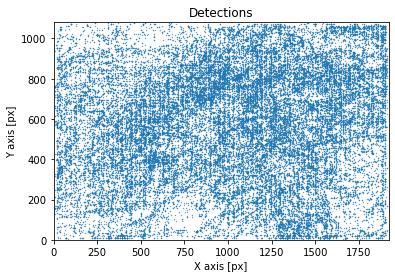

In [4]:
# combine all detections into a single 2D array to produce a simple scatter plot
all_xy = []
for frame in all_detection_centres:
    for detection in frame:
        all_xy.append(detection)
        
all_xy = np.array(all_xy)
all_xy = np.reshape(all_xy, (-1,2)) # ensures the format can be read by matplotlib

plt.scatter(all_xy[:,0],all_xy[:,1],s=0.1)
plt.title("Detections")    
plt.xlabel("X axis [px]")   
plt.ylabel("Y axis [px]")
plt.xlim(0,frame_rgb.shape[1])
plt.ylim(0,frame_rgb.shape[0])
"""
plt.savefig("C:/Users/Legos/Documents/PhD/Blender/OmniTrax/OmniTrax_WIP/benchmark/sub_colony_tracking/RESULTS/" + video[:-4].split("/")[-1] + "_" + 
            yolo_cfg.split("_")[-1][:-4] +'_detections.svg')
"""
plt.show()